In [2]:
import torch
import gpytorch
import numpy as np
import optuna
import matplotlib.pyplot as plt
from src.plotting import plot_gp, plot_alpha_beta, plot_train_test_split

from src.data_loader import PVDataLoader
from src import data_loader as dl
from src.models import ExactGPModel, ApproximateGPBaseModel
from src.hyperparameter_tuning import HyperParameterOptimization
from src.beta_likelihood import BetaLikelihood_MeanParametrization
from optuna.visualization import plot_optimization_history, plot_param_importances

In [3]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 10
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6

==> Loading data
==> Loaded data in: 0 m : 7 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



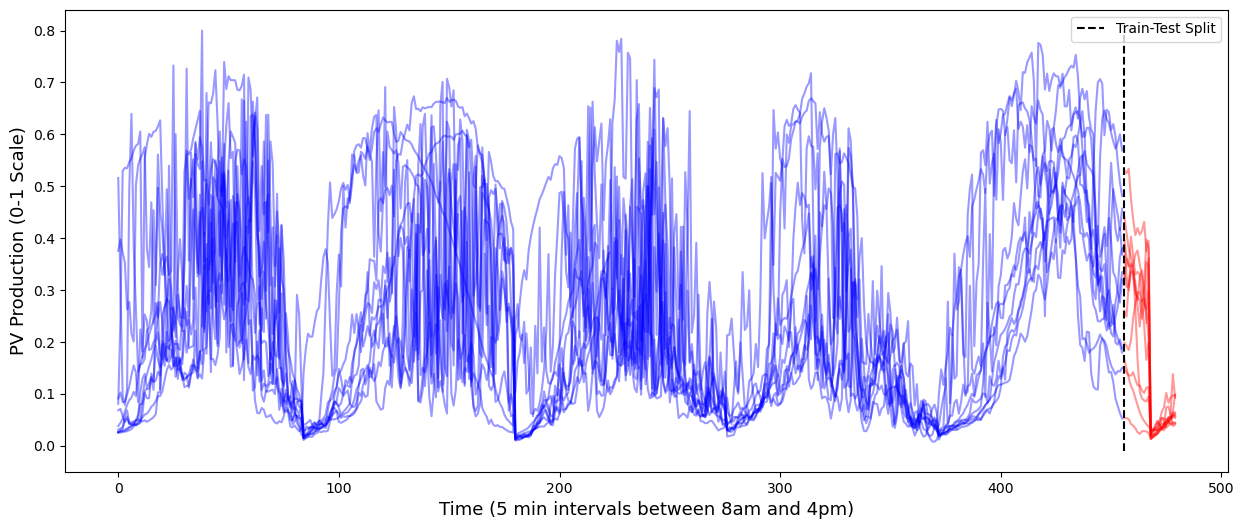

In [4]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

time, y = loader.get_time_series()
x_train, y_train, x_test, y_test = dl.train_test_split(time, y, n_hours=N_HOURS_PRED)
plot_train_test_split(y_train, y_test)

In [5]:
# get individual time series
y_in = y

if y_in.max() > 1:
    y_in[y_in > 1] = 1
# get time related variables
periodic_time = dl.periodic_mapping(time, DAY_MIN, DAY_MAX, MINUTE_INTERVAL)
x = torch.stack([time, periodic_time], dim=1)

# standardize input
x = (x - x.mean(dim=0)) / x.std(dim=0)

# split into train and test
x_train, y_train, x_test, y_test = dl.train_test_split(x, y_in, n_hours=N_HOURS_PRED)

# use all data as inducing points
x_inducing = x_train
y_inducing = y_train

# Stochastic Variational Inference for Gaussian Processes

Limitations:
- stochastic updates which can cause optimization problems and no guarantee of the global optimum is guaranteed, careful initialization and tuning of hyperparameters.
- not exact training data but inducing points (hyperparameter choice)
- not closed form solution for posterior s.t. solution is not exact


Strengths:
- non-gaussian likelihood for flexibility
- scalability
- uncertainty estimation
- approximate inference can capture important aspects of the underlying disitribtuions (giving fairly accurate predictions)

# Kernels

In [6]:
from gpytorch.kernels import MaternKernel, ScaleKernel, AdditiveKernel, ProductKernel, PeriodicKernel
from gpytorch.means import ConstantMean
# TODO add a prior to the period in periodic
matern_base = MaternKernel(nu=3/2, 
                      ard_num_dims=x.shape[1], 
                      lengthscale_prior=gpytorch.priors.GammaPrior(2, 8),
                      lengthscale_constraint=gpytorch.constraints.Positive()
                      )
periodic = PeriodicKernel(period_length_prior=gpytorch.priors.GammaPrior(3, 2),
                            period_length_constraint=gpytorch.constraints.Positive()
                        )
scaled_periodic = ScaleKernel(periodic,
                                outputscale_prior=gpytorch.priors.GammaPrior(5, 1),
                                outputscale_constraint=gpytorch.constraints.Positive()
                            )
scaled_matern = ScaleKernel(matern_base, 
                            outputscale_prior=gpytorch.priors.GammaPrior(5, 2),
                            outputscale_constraint=gpytorch.constraints.Interval(0.1, 1)
                            )
product_kernel = ScaleKernel(periodic * matern_base,
                             outputscale_prior = gpytorch.priors.GammaPrior(5, 2),
                             outputscale_constraint=gpytorch.constraints.Positive()
                            )

quasi_periodic = AdditiveKernel(product_kernel, scaled_matern)


Iter 30/300 - Loss: -0.167
Iter 60/300 - Loss: -0.783
Iter 90/300 - Loss: -0.910
Iter 120/300 - Loss: -0.944
Iter 150/300 - Loss: -0.962
Iter 180/300 - Loss: -0.974
Iter 210/300 - Loss: -0.983
Iter 240/300 - Loss: -0.991
Iter 270/300 - Loss: -0.998
Iter 300/300 - Loss: -1.004


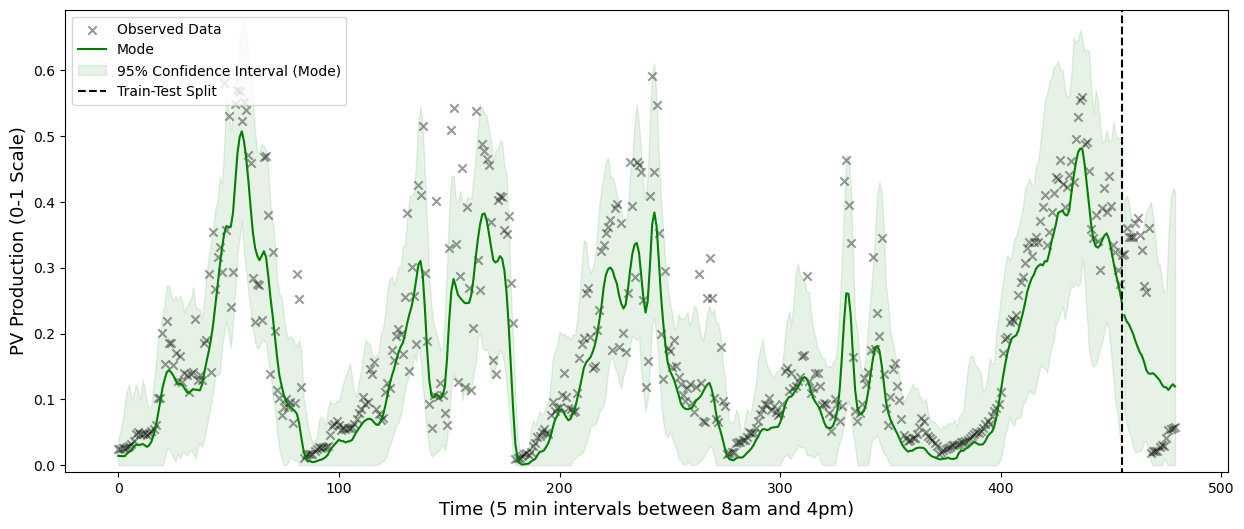

Iter 30/300 - Loss: -0.335
Iter 60/300 - Loss: -0.915
Iter 90/300 - Loss: -1.001
Iter 120/300 - Loss: -1.029
Iter 150/300 - Loss: -1.049
Iter 180/300 - Loss: -1.066
Iter 210/300 - Loss: -1.080
Iter 240/300 - Loss: -1.092
Iter 270/300 - Loss: -1.103
Iter 300/300 - Loss: -1.113


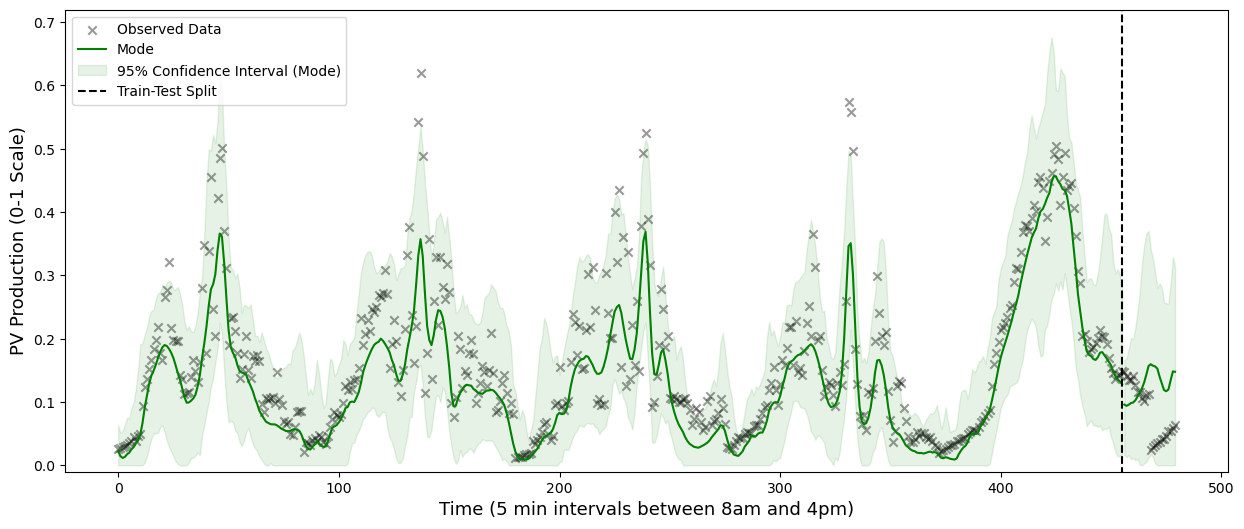

Iter 30/300 - Loss: -0.419
Iter 60/300 - Loss: -0.922
Iter 90/300 - Loss: -1.001
Iter 120/300 - Loss: -1.028
Iter 150/300 - Loss: -1.047
Iter 180/300 - Loss: -1.063
Iter 210/300 - Loss: -1.077
Iter 240/300 - Loss: -1.089
Iter 270/300 - Loss: -1.099
Iter 300/300 - Loss: -1.109


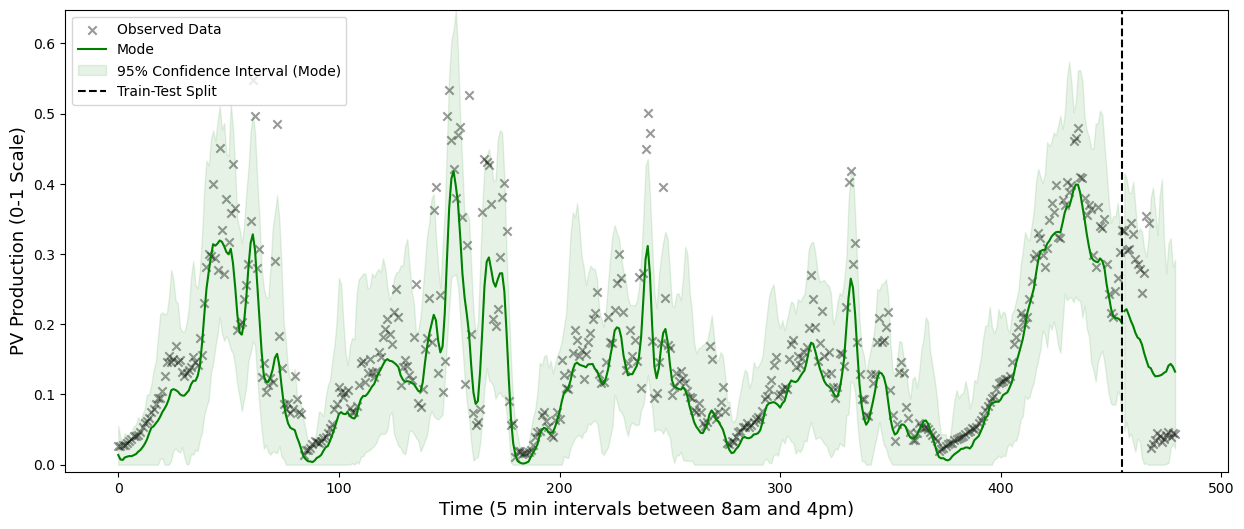

Iter 30/300 - Loss: -0.437
Iter 60/300 - Loss: -0.772
Iter 90/300 - Loss: -0.814
Iter 120/300 - Loss: -0.829
Iter 150/300 - Loss: -0.841
Iter 180/300 - Loss: -0.851
Iter 210/300 - Loss: -0.859
Iter 240/300 - Loss: -0.865
Iter 270/300 - Loss: -0.871
Iter 300/300 - Loss: -0.876


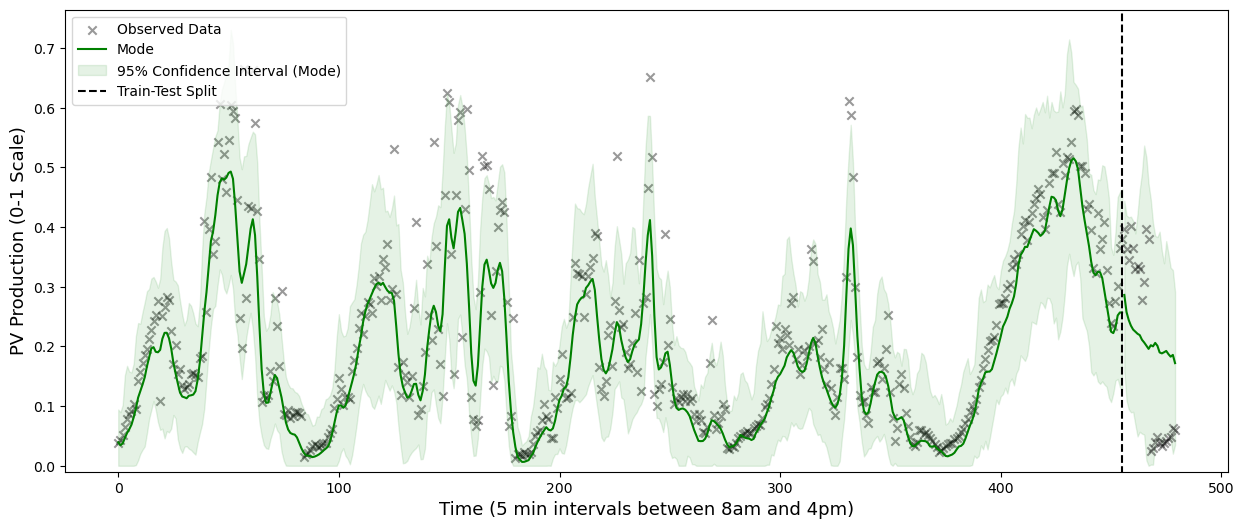

Iter 30/300 - Loss: -0.051
Iter 60/300 - Loss: -0.514
Iter 90/300 - Loss: -0.565
Iter 120/300 - Loss: -0.577
Iter 150/300 - Loss: -0.583
Iter 180/300 - Loss: -0.587
Iter 210/300 - Loss: -0.590
Iter 240/300 - Loss: -0.592
Iter 270/300 - Loss: -0.593
Iter 300/300 - Loss: -0.594


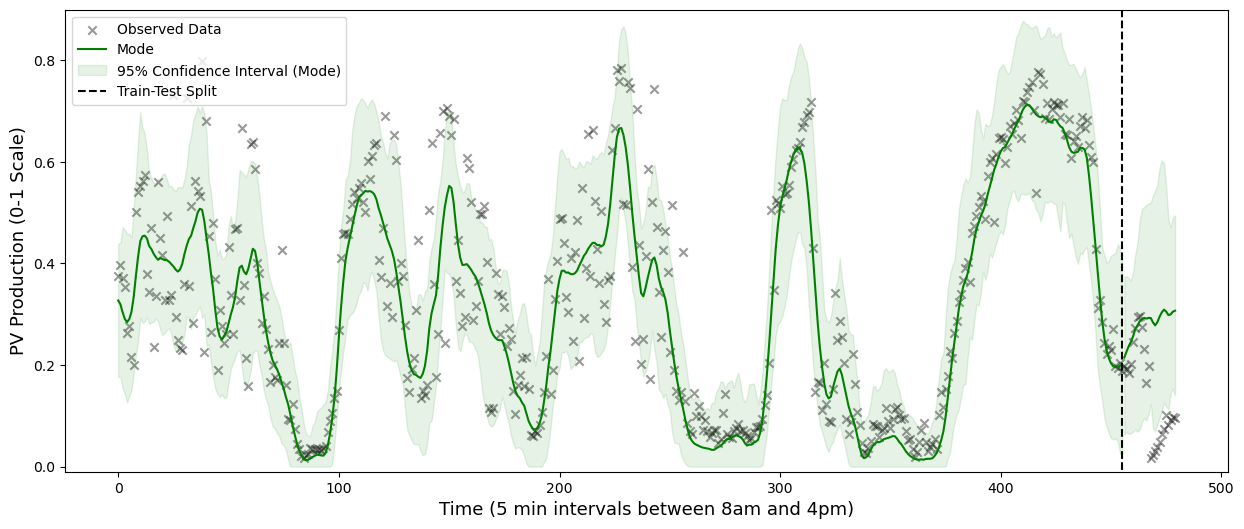

Iter 30/300 - Loss: -0.080
Iter 60/300 - Loss: -0.746
Iter 90/300 - Loss: -0.865
Iter 120/300 - Loss: -0.892
Iter 150/300 - Loss: -0.906
Iter 180/300 - Loss: -0.917
Iter 210/300 - Loss: -0.926
Iter 240/300 - Loss: -0.934
Iter 270/300 - Loss: -0.940
Iter 300/300 - Loss: -0.945


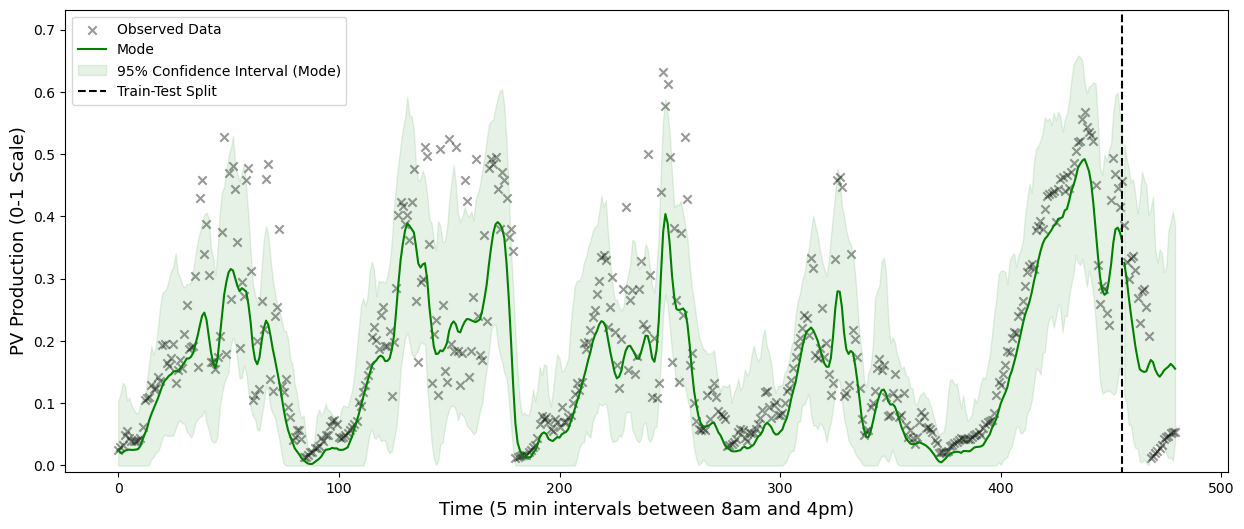

Iter 30/300 - Loss: -0.318
Iter 60/300 - Loss: -0.723
Iter 90/300 - Loss: -0.766
Iter 120/300 - Loss: -0.779
Iter 150/300 - Loss: -0.788
Iter 180/300 - Loss: -0.796
Iter 210/300 - Loss: -0.801
Iter 240/300 - Loss: -0.806
Iter 270/300 - Loss: -0.809
Iter 300/300 - Loss: -0.812


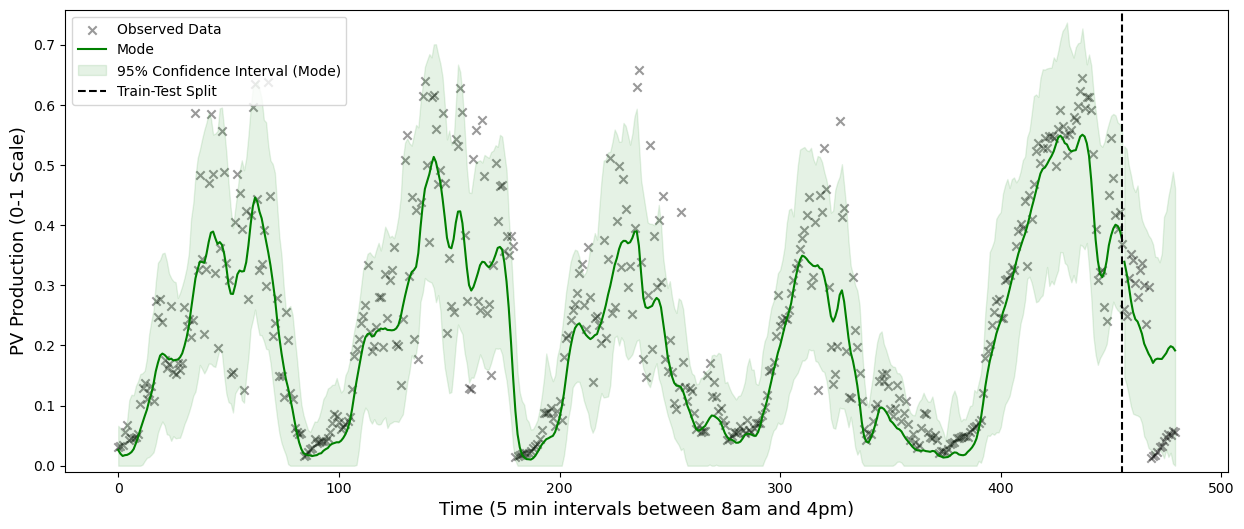

Iter 30/300 - Loss: -0.123
Iter 60/300 - Loss: -0.606
Iter 90/300 - Loss: -0.687
Iter 120/300 - Loss: -0.712
Iter 150/300 - Loss: -0.728
Iter 180/300 - Loss: -0.739
Iter 210/300 - Loss: -0.749
Iter 240/300 - Loss: -0.756
Iter 270/300 - Loss: -0.762
Iter 300/300 - Loss: -0.767


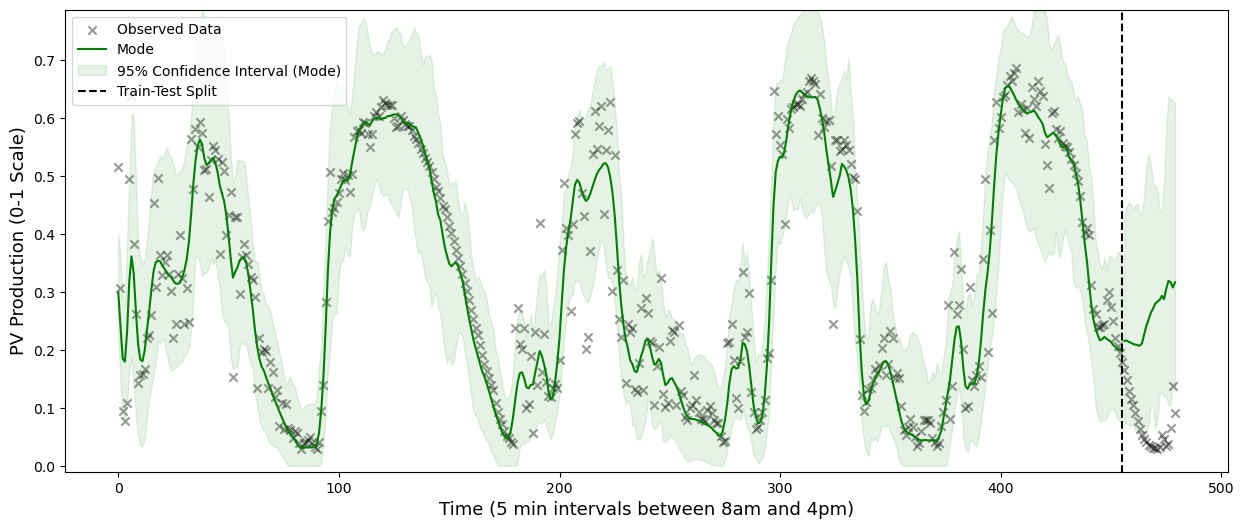

Iter 30/300 - Loss: -0.279
Iter 60/300 - Loss: -0.750
Iter 90/300 - Loss: -0.816
Iter 120/300 - Loss: -0.837
Iter 150/300 - Loss: -0.852
Iter 180/300 - Loss: -0.862
Iter 210/300 - Loss: -0.871
Iter 240/300 - Loss: -0.877
Iter 270/300 - Loss: -0.883
Iter 300/300 - Loss: -0.887


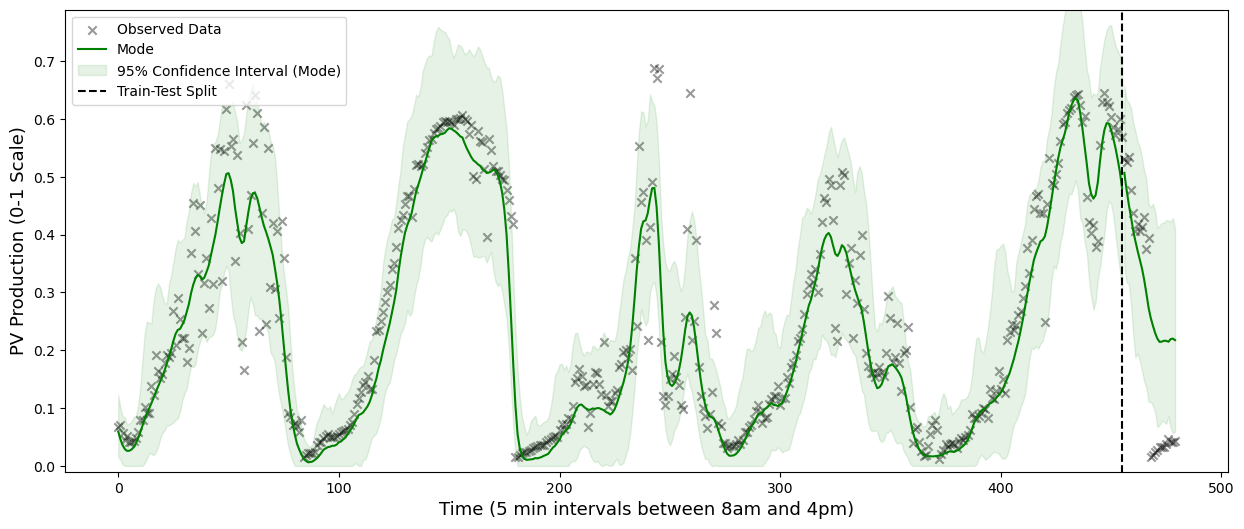

Iter 30/300 - Loss: -0.140
Iter 60/300 - Loss: -0.657
Iter 90/300 - Loss: -0.723
Iter 120/300 - Loss: -0.744
Iter 150/300 - Loss: -0.758
Iter 180/300 - Loss: -0.769
Iter 210/300 - Loss: -0.777
Iter 240/300 - Loss: -0.784
Iter 270/300 - Loss: -0.789
Iter 300/300 - Loss: -0.793


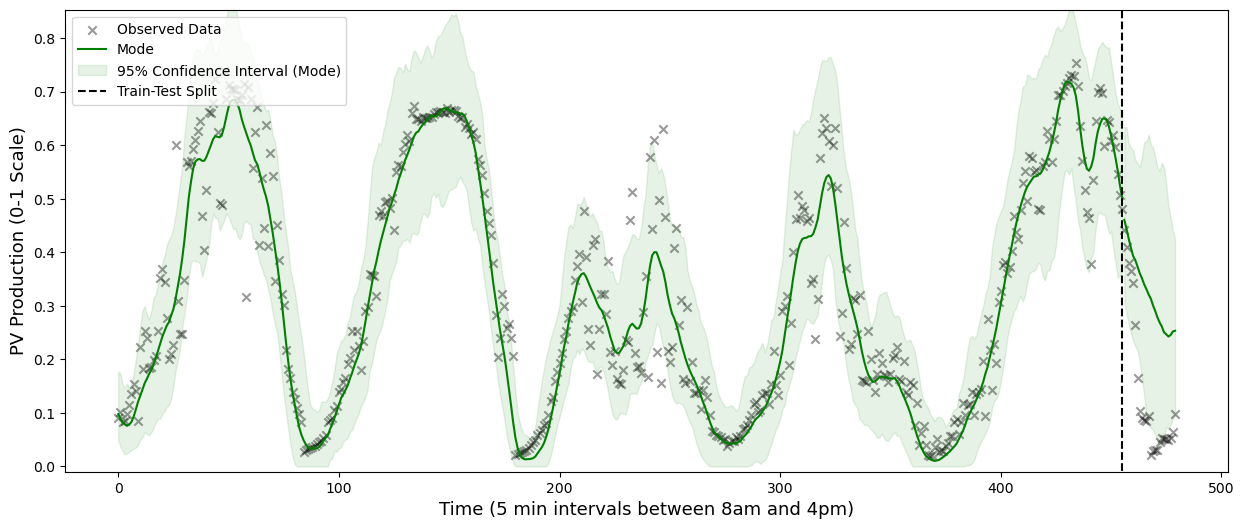

Iter 30/300 - Loss: -0.137
Iter 60/300 - Loss: -0.626
Iter 90/300 - Loss: -0.723
Iter 120/300 - Loss: -0.756
Iter 150/300 - Loss: -0.772
Iter 180/300 - Loss: -0.783
Iter 210/300 - Loss: -0.791
Iter 240/300 - Loss: -0.798
Iter 270/300 - Loss: -0.804
Iter 300/300 - Loss: -0.809


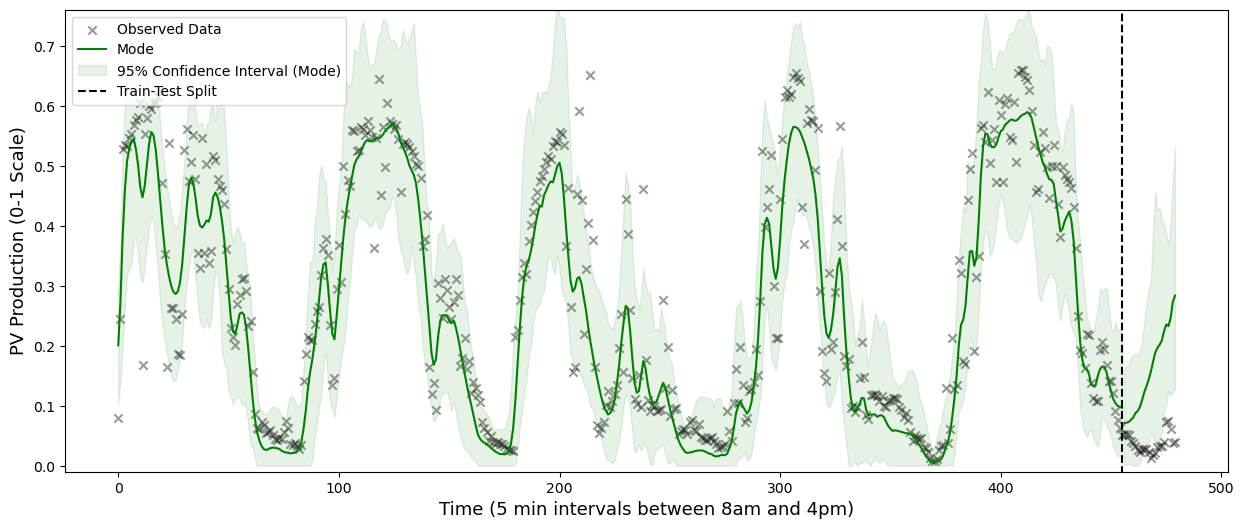

In [8]:
jitter = 1e-4
config = {  'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_inducing.size(0),
            'mean_init_std': 2,
            }

for idx in range(y_train.size(1)):
    
  
    inputs_mean = { 'X': x_train, 
                    'y': y_train[:, idx], 
                    'mean_module': gpytorch.means.ConstantMean(),
                    'covar_module': scaled_matern,
                    'likelihood': BetaLikelihood_MeanParametrization(scale=10,
                                                                     correcting_scale=1,
                                                                     lower_bound=0.10,
                                                                     upper_bound=0.80),
                    'config': config,
                    'jitter': jitter
                }

    model_beta = ApproximateGPBaseModel(**inputs_mean)
    model_beta.fit(n_iter=300, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'), verbose=True)    
    
    preds = model_beta.predict(x, device=torch.device('cpu'))
    plot_gp(model_beta, x_train, x_test, y_train[:,idx], y_test[:,idx], y_inducing=y_inducing[:,idx], pred_type='both')


# Hyperparameter Optimization

In [8]:
config = {'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_train.size(0),
            'mean_init_std': 1,
            }

jitter = 1e-4

hyper_opt = HyperParameterOptimization( model='beta',
                                        x_train=x_train,
                                        y_train=y_train,
                                        x_test=x_test,
                                        y_test=y_test,
)
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: hyper_opt.objective(trial, config, jitter, kernel='matern'), n_trials=10)

[I 2023-06-28 15:49:26,222] A new study created in memory with name: no-name-bddeaeaf-a966-4f94-ab59-4a13fb380c66
/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 30] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 26].
  warnings.warn(
[I 2023-06-28 15:52:11,973] Trial 0 finished with value: 0.044488128274679184 and parameters: {'matern_L_shape': 2.0, 'matern_L_rate': 6.0, 'signal_matern_shape': 7.0, 'signal_matern_rate': 9.0, 'likelihood_scale': 16, 'likelihood_correcting_scale': 3.0, 'lr': 0.30000000000000004}. Best is trial 0 with value: 0.044488128274679184.
[I 2023-06-28 15:54:52,988] Trial 1 finished with value: 0.04648548364639282 and parameters: {'matern_L_shape': 1.0, 'matern_L_rate': 3.0, 'signal_matern_shape': 2.0, 'signal_matern_rate': 7.0, 'likelihood_scale': 26, 'likelihood_correcting_scale': 3.0, 'lr': 0.1}. Best is trial 0 with value:

In [8]:
from optuna.visualization import plot_optimization_history, plot_contour, plot_parallel_coordinate, plot_param_importances

In [9]:
plot_optimization_history(study)

In [12]:
plot_contour(study, params=[ 'period_P_shape', 'period__P_rate'])

In [13]:
plot_parallel_coordinate(study)

In [14]:
plot_param_importances(study)

In [15]:
best_params = study.best_params
best_params

{'matern_L_shape': 5.0,
 'matern_L_rate': 4.0,
 'signal_matern_shape': 7.0,
 'signal_matern_rate': 5.0,
 'periodic_L_shape': 5.0,
 'period_L_rate': 2.0,
 'period_P_shape': 5.0,
 'period__P_rate': 2.0,
 'signal_periodic_shape': 9.0,
 'signal_periodic_rate': 1.0,
 'likelihood_scale': 16,
 'likelihood_correcting_scale': 1.0,
 'lr': 0.1}

In [21]:
matern_lengthscale_shape = best_params['matern_L_shape']
matern_lengthscale_rate = best_params['matern_L_rate']
signal_matern_shape = best_params['signal_matern_shape']
signal_matern_rate = best_params['signal_matern_rate']
periodic_lengthscale_shape = best_params['periodic_L_shape']
periodic_lengthscale_rate = best_params['period_L_rate']
periodic_period_shape = best_params['period_P_shape']
periodic_period_rate = best_params['period__P_rate']
signal_periodic_shape = best_params['signal_periodic_shape']
signal_periodic_rate = best_params['signal_periodic_rate']
likelihood_scale = best_params['likelihood_scale']
likelihood_correcting_scale = best_params['likelihood_correcting_scale']
lr = best_params['lr']

matern_base = MaternKernel(nu=3/2,
                        ard_num_dims=x.shape[1],
                        lengthscale_prior=gpytorch.priors.GammaPrior(matern_lengthscale_shape, matern_lengthscale_rate),
                        lengthscale_constraint=gpytorch.constraints.Positive()
                        )
scaled_matern = ScaleKernel(matern_base,
                            outputscale_prior=gpytorch.priors.GammaPrior(signal_matern_shape, signal_matern_rate),
                            outputscale_constraint=gpytorch.constraints.Positive()
                            )
periodic = PeriodicKernel(  period_prior=gpytorch.priors.GammaPrior(periodic_period_shape, periodic_period_rate),
                            period_constraint=gpytorch.constraints.Positive(),
                            lengthscale_prior=gpytorch.priors.GammaPrior(periodic_lengthscale_shape, periodic_lengthscale_rate),
                            lengthscale_constraint=gpytorch.constraints.Positive()
                        )
scaled_periodic = ScaleKernel(periodic,
                                outputscale_prior=gpytorch.priors.GammaPrior(signal_periodic_shape, signal_periodic_rate),
                                outputscale_constraint=gpytorch.constraints.Positive()
                            )
product_kernel = ProductKernel(scaled_periodic, scaled_matern)
add_kernel = AdditiveKernel(product_kernel, scaled_matern)

Iter 30/300 - Loss: -0.569
Iter 60/300 - Loss: -0.934
Iter 90/300 - Loss: -0.987
Iter 120/300 - Loss: -0.994
Iter 150/300 - Loss: -0.996
Iter 180/300 - Loss: -0.999
Iter 210/300 - Loss: -1.000
Iter 240/300 - Loss: -1.002
Iter 270/300 - Loss: -1.004
Iter 300/300 - Loss: -1.005


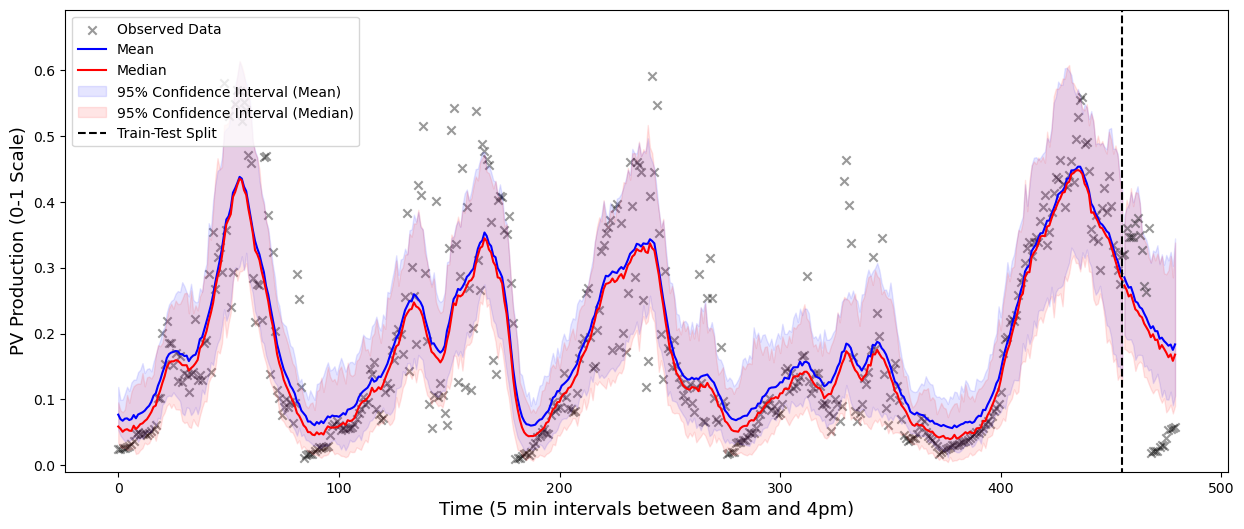

Iter 30/300 - Loss: -0.883
Iter 60/300 - Loss: -1.082
Iter 90/300 - Loss: -1.116
Iter 120/300 - Loss: -1.126
Iter 150/300 - Loss: -1.133
Iter 180/300 - Loss: -1.140
Iter 210/300 - Loss: -1.146
Iter 240/300 - Loss: -1.151
Iter 270/300 - Loss: -1.156
Iter 300/300 - Loss: -1.161


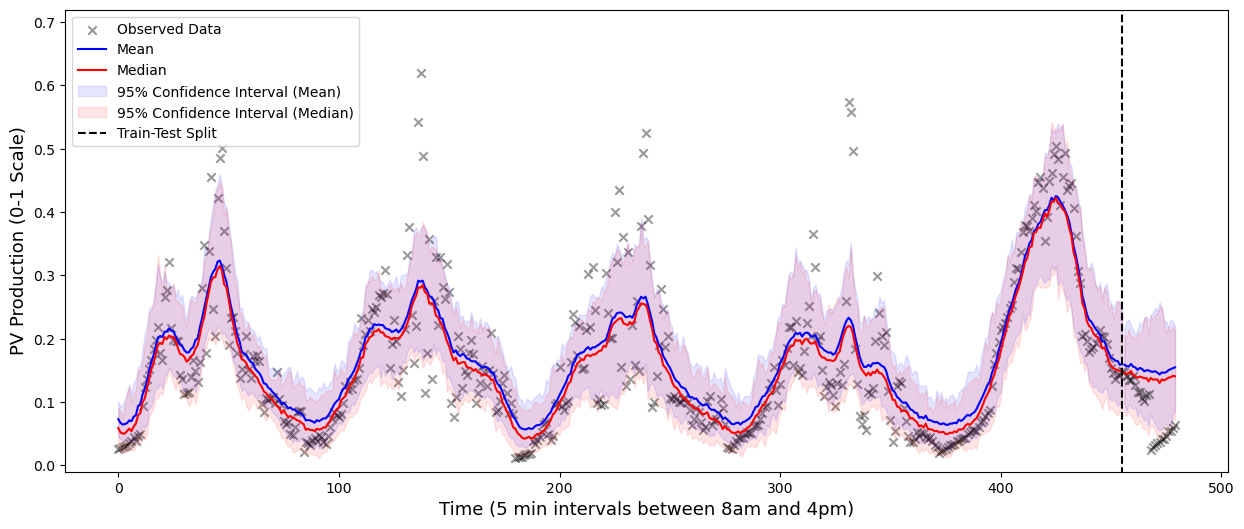

Iter 30/300 - Loss: -0.721
Iter 60/300 - Loss: -1.064
Iter 90/300 - Loss: -1.103
Iter 120/300 - Loss: -1.111
Iter 150/300 - Loss: -1.117
Iter 180/300 - Loss: -1.122
Iter 210/300 - Loss: -1.127
Iter 240/300 - Loss: -1.132
Iter 270/300 - Loss: -1.136
Iter 300/300 - Loss: -1.140


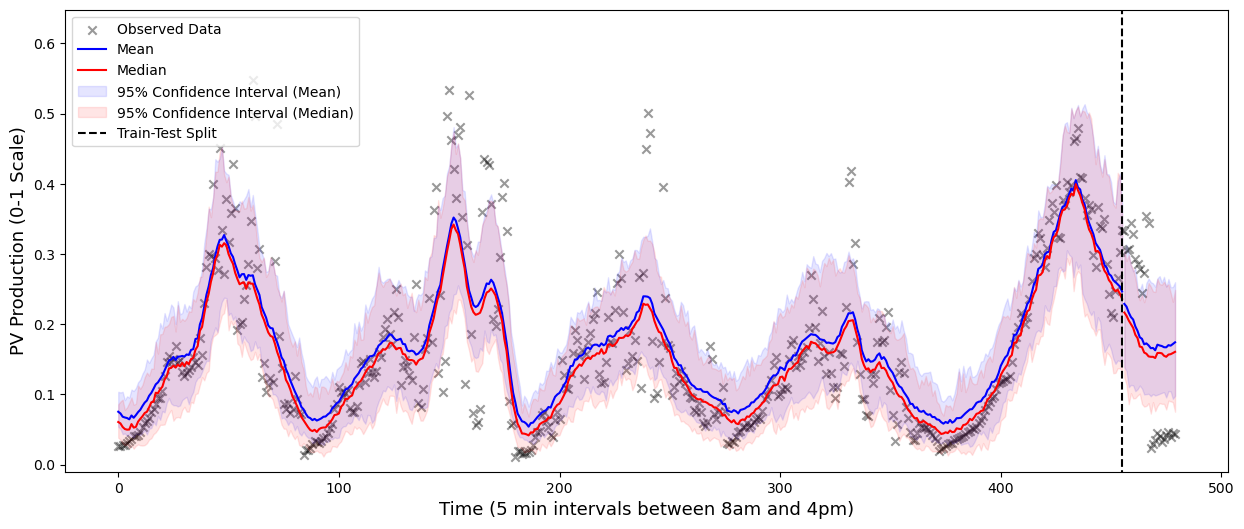

Iter 30/300 - Loss: -0.579
Iter 60/300 - Loss: -0.834
Iter 90/300 - Loss: -0.851
Iter 120/300 - Loss: -0.853
Iter 150/300 - Loss: -0.855
Iter 180/300 - Loss: -0.857
Iter 210/300 - Loss: -0.858
Iter 240/300 - Loss: -0.859
Iter 270/300 - Loss: -0.860
Iter 300/300 - Loss: -0.861


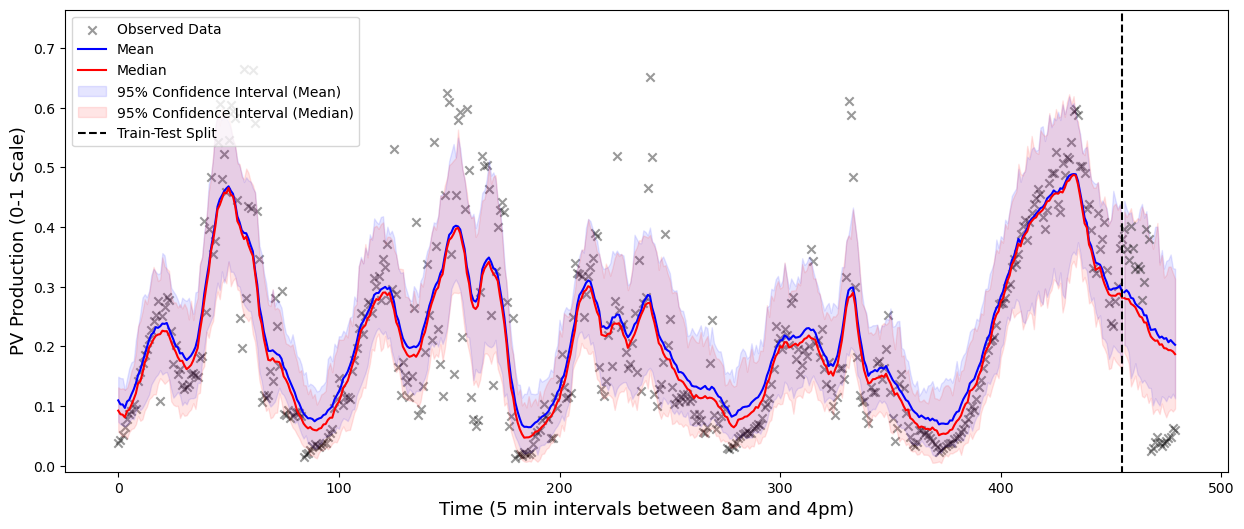

Iter 30/300 - Loss: -0.343
Iter 60/300 - Loss: -0.554
Iter 90/300 - Loss: -0.564
Iter 120/300 - Loss: -0.565
Iter 150/300 - Loss: -0.565
Iter 180/300 - Loss: -0.565
Iter 210/300 - Loss: -0.565
Iter 240/300 - Loss: -0.565
Iter 270/300 - Loss: -0.565
Iter 300/300 - Loss: -0.565


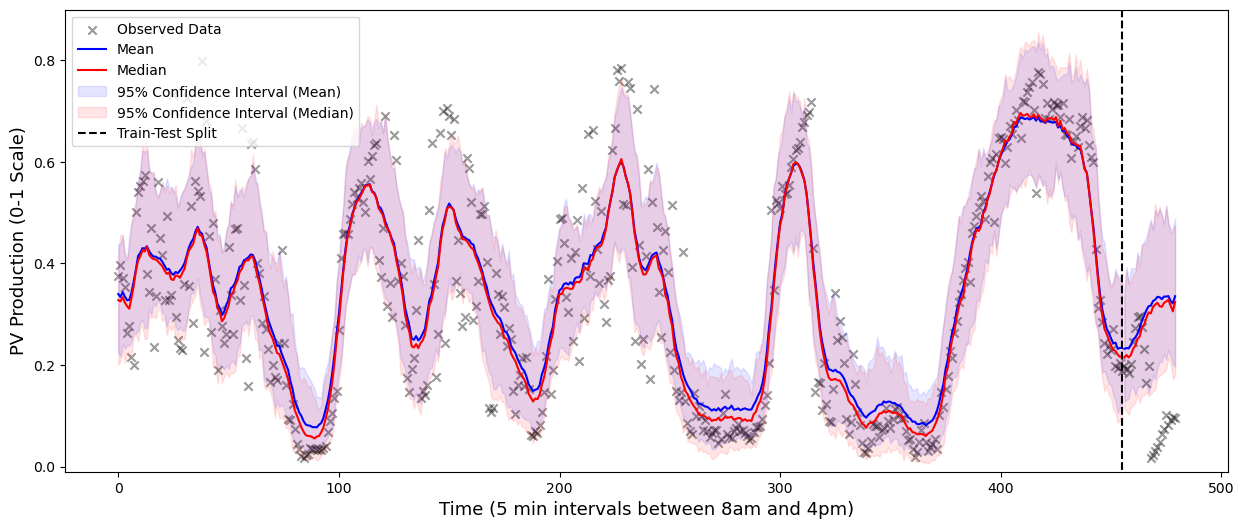

Iter 30/300 - Loss: -0.530
Iter 60/300 - Loss: -0.883
Iter 90/300 - Loss: -0.934
Iter 120/300 - Loss: -0.940
Iter 150/300 - Loss: -0.942
Iter 180/300 - Loss: -0.944
Iter 210/300 - Loss: -0.946
Iter 240/300 - Loss: -0.947
Iter 270/300 - Loss: -0.949
Iter 300/300 - Loss: -0.950


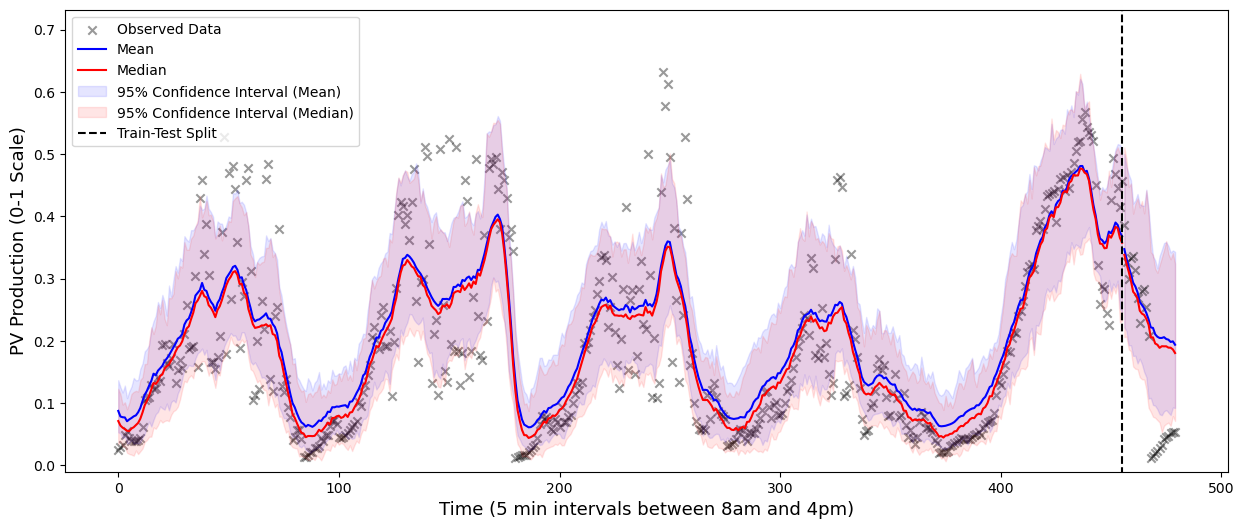

Iter 30/300 - Loss: -0.500
Iter 60/300 - Loss: -0.788
Iter 90/300 - Loss: -0.807
Iter 120/300 - Loss: -0.810
Iter 150/300 - Loss: -0.811
Iter 180/300 - Loss: -0.811
Iter 210/300 - Loss: -0.812
Iter 240/300 - Loss: -0.813
Iter 270/300 - Loss: -0.813
Iter 300/300 - Loss: -0.814


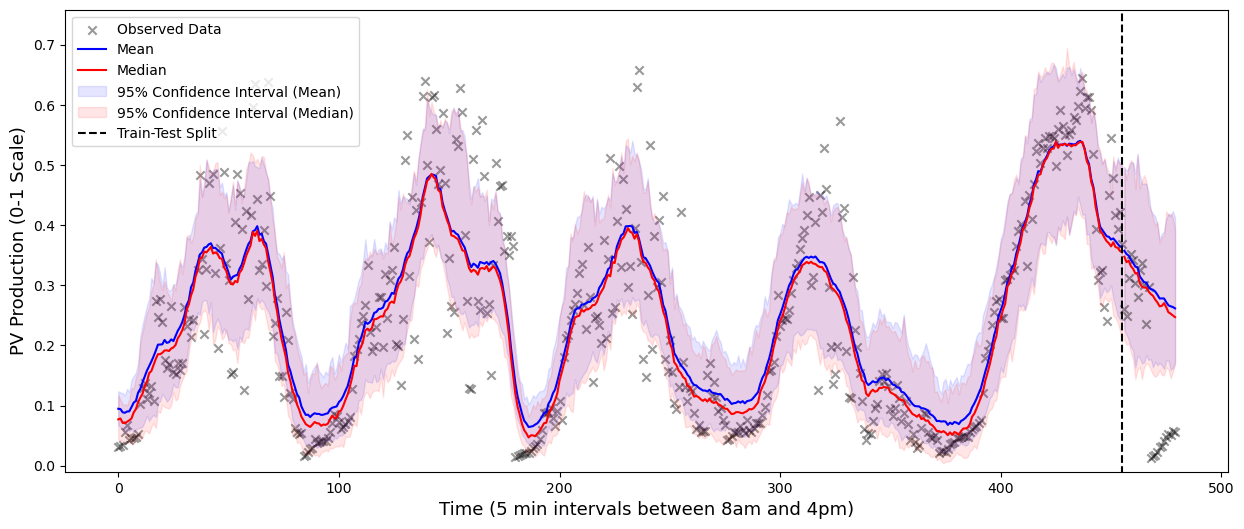

Iter 30/300 - Loss: -0.513
Iter 60/300 - Loss: -0.715
Iter 90/300 - Loss: -0.732
Iter 120/300 - Loss: -0.737
Iter 150/300 - Loss: -0.742
Iter 180/300 - Loss: -0.746
Iter 210/300 - Loss: -0.749
Iter 240/300 - Loss: -0.751
Iter 270/300 - Loss: -0.754
Iter 300/300 - Loss: -0.755


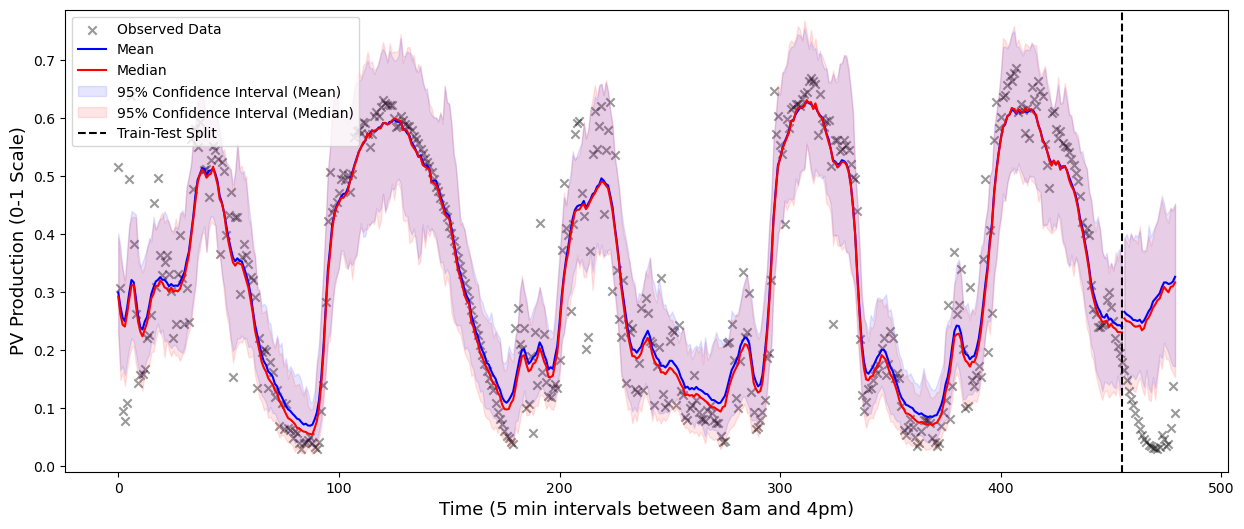

Iter 30/300 - Loss: -0.382
Iter 60/300 - Loss: -0.813
Iter 90/300 - Loss: -0.847
Iter 120/300 - Loss: -0.854
Iter 150/300 - Loss: -0.857
Iter 180/300 - Loss: -0.860
Iter 210/300 - Loss: -0.863
Iter 240/300 - Loss: -0.866
Iter 270/300 - Loss: -0.868
Iter 300/300 - Loss: -0.870


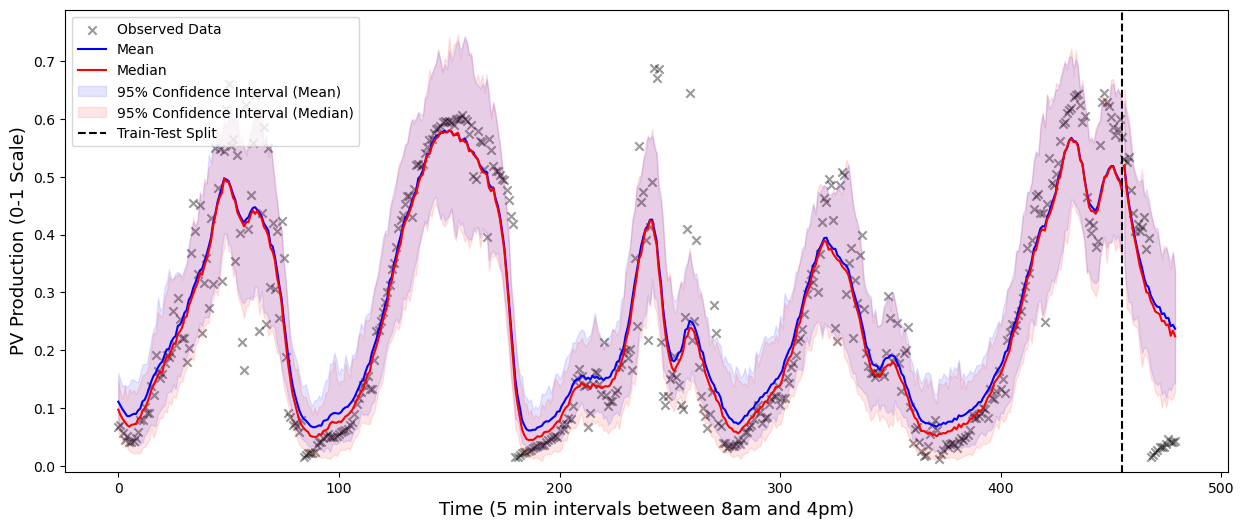

Iter 30/300 - Loss: -0.542
Iter 60/300 - Loss: -0.756
Iter 90/300 - Loss: -0.775
Iter 120/300 - Loss: -0.781
Iter 150/300 - Loss: -0.786
Iter 180/300 - Loss: -0.791
Iter 210/300 - Loss: -0.794
Iter 240/300 - Loss: -0.797
Iter 270/300 - Loss: -0.800
Iter 300/300 - Loss: -0.802


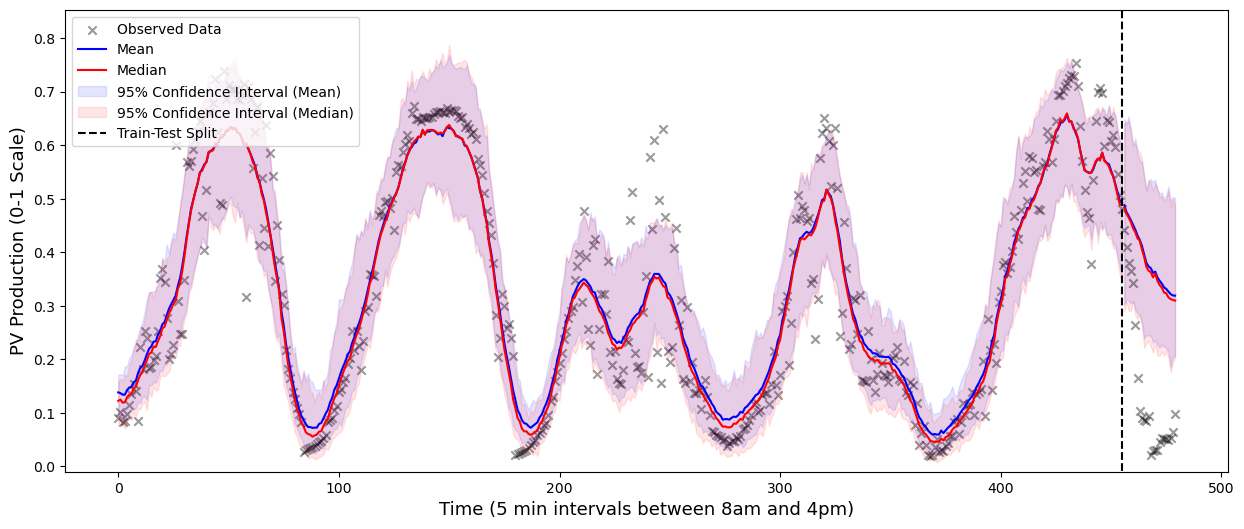

Iter 30/300 - Loss: -0.490
Iter 60/300 - Loss: -0.735
Iter 90/300 - Loss: -0.766
Iter 120/300 - Loss: -0.773
Iter 150/300 - Loss: -0.777
Iter 180/300 - Loss: -0.779
Iter 210/300 - Loss: -0.781
Iter 240/300 - Loss: -0.783
Iter 270/300 - Loss: -0.785
Iter 300/300 - Loss: -0.786


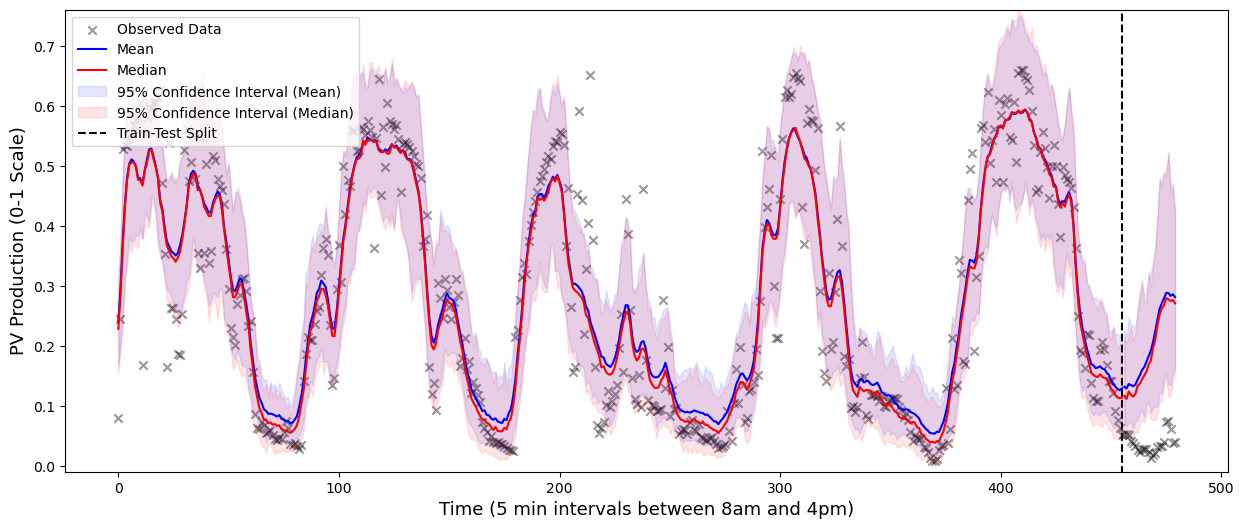

In [31]:
jitter = 1e-4

for idx in range(y_train.size(1)):
    
    config = {  'type': 'stochastic',
                'name': 'mean_field',
                'num_inducing_points': x_inducing.size(0),
                'mean_init_std': 1,
                }
    inputs_mean = { 'X': x_train, 'y': y_train[:, idx], 
                    'mean_module': gpytorch.means.ConstantMean(),
                    'covar_module': add_kernel,
                    'likelihood': BetaLikelihood_MeanParametrization(scale=likelihood_scale,
                                                                     correcting_scale=likelihood_correcting_scale,
                                                                     lower_bound=0.10,
                                                                     upper_bound=0.80),
                    'config': config,
                    'jitter': jitter
                }

    model_beta = BetaGP(**inputs_mean)
    model_beta.fit(n_iter=300, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'), verbose=True)    
    
    preds = model_beta.predict(x, device=torch.device('cpu'))
    plot_gp(model_beta, x_train, x_test, y_train[:,idx], y_test[:,idx], y_inducing=y_inducing[:,idx])